In [110]:
import numpy as np
from pathlib import Path
from utils import project_root
from scipy.spatial.transform import Rotation
import numpy as np
import os
import pymap3d as pm
from random import randrange
import matplotlib.pyplot as plt

%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,10)

# Globals

In [111]:
# GLOBAL VARIABLES
# IMU rotational offset
imu_rot_off = [0, 0, 1.5708]
# rotation from base_link to IMU
R_b2i = Rotation.from_euler('z', 1.5708, degrees=False).as_matrix()
# GPS translational offset
x_off = -0.01
y_off = 0
z_off = 2.13
gps_off = np.array([x_off, y_off, z_off]).reshape((3,1))
# radar translational offset
radar_off = np.array([0.915, 0, 0.895]).reshape((3,1))
# gravity
GRAV = 9.80665

# define covariances
# GPS position_covariance:
gps_pos_cov = [[0.019599999999999996, 0, 0],
               [0, 0.019599999999999996, 0],
               [0, 0, 0.31359999999999993]]
# IMU covariances (noise) from /ouster/imu topic
lin_acc_cov = [[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]]
ang_vel_cov = [[0.0006, 0, 0],
              [0, 0.0006, 0],
              [0, 0, 0.0006]]
# extract variances and std. deviations
var_p = 0.019599999999999996
sigma_p = np.sqrt(var_p)
var_a = 0.01
sigma_a = np.sqrt(var_a)
var_w = 0.0006
sigma_w = np.sqrt(var_w)
# we manual tune the radar std. deviation and variance
sigma_r = 0.1
var_r = sigma_r**2

# rotation order
rot_order = 'xyz'

# common terms
I3 = np.identity(3)
O3 = np.zeros((3,3))

# Helpers

In [112]:
# rotation order
rot_order = 'xyz'

# function to return the index of the closest IMU reading to the given timestamp
def get_IMU_reading(time, imu_times):
    min_dt = 10000
    for idx, stamp in enumerate(imu_times):
        #print(stamp, time)
        dt = abs(stamp - time)
        if dt<min_dt:
            min_dt = dt
            min_idx = idx
            
        # if we found a very close reading, stop
        if min_dt < 0.01:
            break

    return min_dt, min_idx

# page 25, Sola's
def quat2matrix(q):
    qw, qx, qy, qz = q
    
    R = [[qw**2 + qx**2 - qy**2 - qz**2, 2*(qx*qy - qw*qz),             2*(qx*qz + qw*qy)],
         [2*(qx*qy + qw*qz),             qw**2 - qx**2 + qy**2 - qz**2, 2*(qy*qz - qw*qx)],
         [2*(qx*qz - qw*qy),             2*(qy*qz + qw*qx),             qw**2 - qx**2 - qy**2 + qz**2]]
    
    return np.array(R).reshape((3,3))

# as defined in Sola, page 6
# The product of two rotation quaternions will be equivalent to the rotation a2 + b2i + c2j + d2k (q1)
# followed by the rotation a1 + b1i + c1j + d1k (q0).
def quat_mult(p, q):
    pw, px, py, pz = p
    qw, qx, qy, qz = q
    
    q_w = pw*qw - px*qx - py*qy - pz*qz
    q_x = pw*qx + px*qw + py*qz - pz*qy
    q_y = pw*qy - px*qz + py*qw + pz*qx
    q_z = pw*qz + px*qy - py*qx + pz*qw
    
    retq = np.array([q_w, q_x, q_y, q_z]).reshape((4,1))

    return retq

# convert euler to quaternion
def euler2quat(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_quat = rot.as_quat() # [x, y, z, w]
    
    retval = np.array([rot_quat[3], rot_quat[0], rot_quat[1], rot_quat[2]]).reshape((4,1)) # [w, x, y, z]
    
    return retval

# get rotation matrix from euler angles
def euler2matrix(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_matrix = rot.as_matrix().reshape((3,3))
        
    return rot_matrix

# convert quaternions to euler
def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

# extract euler angles from rotation matrix
def matrix2euler(R_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_matrix(R_in)

    # Convert to quaternions
    rot_e = rot.as_euler(axis).reshape((3,1))
        
    return rot_e

# Preprocess

In [113]:
# load GPS data
def LoadGPS():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('gps.txt') as f:
        lines = f.readlines()

        lattitude = []
        longitude = []
        altitude = []
        sec_gps = []
        nsec_gps = []
        count = 0
        for line in lines:
            count += 1
            if line[4:7] == "sec":
                sec_gps.append(int(line[9:-1]))
            elif line[4:11] == "nanosec":
                nsec_gps.append(int(line[13:-1]))
            elif line[0:3] == "lat":
                lattitude.append(float(line[10:-1]))
            elif line[0:3] == "lon":
                longitude.append(float(line[11:-1]))
            elif line[0:3] == "alt":
                altitude.append(float(line[10:-1]))

    temp = [i*1e-9 for i in nsec_gps]
    t_gps = [sum(x) for x in zip(sec_gps, temp)]
    tt_gps = np.array([x-t_gps[0] for x in t_gps])

    # convert lat,long,alt to x,y,z
    lat_0 = lattitude[0]
    lon_0 = longitude[0]
    alt_0 = altitude[0]

    x_gps = []
    y_gps = []
    z_gps = []
    for i in range(len(lattitude)):
        # get [east, noth, up] w.r.t. an origin and assume it is [y, x, z]
        x_, y_, z_ = pm.geodetic2enu(lattitude[i], longitude[i], altitude[i], lat_0, lon_0, alt_0, ell=None, deg=True)
        # add the extrinsic calibration offset, so that the coordinates are w.r.t. "base_link", not "gps"
        x_gps.append(x_ + gps_off[0])
        y_gps.append(y_ + gps_off[1])
        z_gps.append(z_ + gps_off[2])

    x_gps = np.array(x_gps)
    y_gps = np.array(y_gps)
    z_gps = np.array(z_gps)

    # extract linear velocities from differentiating gps positions
    vx_gps = []
    vy_gps = []
    vz_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            vx, vy, vz = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            vx = (x_gps.flatten()[i] - x_gps.flatten()[i-1])/dt
            vy = (y_gps.flatten()[i] - y_gps.flatten()[i-1])/dt
            vz = (z_gps.flatten()[i] - z_gps.flatten()[i-1])/dt
            
        vx_gps.append(vx)
        vy_gps.append(vy)
        vz_gps.append(vz)

    vx_gps = np.array(vx_gps)
    vy_gps = np.array(vy_gps)
    vz_gps = np.array(vz_gps)

    # extract linear accelerations from double differentation of gps positions
    ax_gps = []
    ay_gps = []
    az_gps = []
    for i in range(len(tt_gps)):

        # in the first iteration, get x,y from gps and theta from imu
        if i==0:
            ax, ay, az = 0, 0, 0
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_gps[i] - tt_gps[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")

            # now depending on dt and the linear and angular velocities, we can upgate the positions with kinematics
            ax = (vx_gps.flatten()[i] - vx_gps.flatten()[i-1])/dt
            ay = (vy_gps.flatten()[i] - vy_gps.flatten()[i-1])/dt
            az = (vz_gps.flatten()[i] - vz_gps.flatten()[i-1])/dt
            
        ax_gps.append(ax)
        ay_gps.append(ay)
        az_gps.append(az)

    ax_gps = np.array(ax_gps)
    ay_gps = np.array(ay_gps)
    az_gps = np.array(az_gps)

    # extract GPS bias from the first 3 seconds of the video, where the vehicle is static
    gps_bias = np.array([np.mean(x_gps[0:30]), np.mean(y_gps[0:30]), np.mean(z_gps[0:30])])

    # combine position, velocity and acceleration data into single arrays
    p_gps = np.hstack((x_gps, y_gps, z_gps))
    v_gps = np.hstack((vx_gps.reshape((-1,1)), vy_gps.reshape((-1,1)), vz_gps.reshape((-1,1))))
    a_gps = np.hstack((ax_gps.reshape((-1,1)), ay_gps.reshape((-1,1)), az_gps.reshape((-1,1))))

    return tt_gps, p_gps, v_gps, a_gps, gps_bias

# load IMU data
def LoadIMU():
    os.chdir(Path(project_root() / 'data/topics'))
    # load ROS data from txt file
    lines = []
    with open('imu.txt') as f:
        lines = f.readlines()

    ang_vel = [] # [w_x, w_y, w_z]
    ang_vel_e = []
    lin_acc = [] # [x_ddot, y_ddot, z_ddot]
    sec_imu = []
    nsec_imu = []
    count = 0

    for idx, line in enumerate(lines):
        count += 1
        if line[4:7] == "sec":
            sec_imu.append(int(line[9:-1]))
        elif line[4:11] == "nanosec":
            nsec_imu.append(int(line[13:-1]))
        elif line[0:-1] == "orientation:":
            qx = float(lines[idx+1][5:-1])
            qy = float(lines[idx+2][5:-1])
            qz = float(lines[idx+3][5:-1])
            qw = float(lines[idx+4][5:-1])
        elif line[0:-1] == "angular_velocity:":
            w_x = float(lines[idx+1][5:-1])
            w_y = float(lines[idx+2][5:-1])
            w_z = float(lines[idx+3][5:-1])
            ang_vel.append([w_x, w_y, w_z])
            ang_vel_e.append([np.rad2deg(w_x), np.rad2deg(w_y), np.rad2deg(w_z)])
        elif line[0:-1] == "linear_acceleration:":
            a_x = float(lines[idx+1][5:-1])
            a_y = float(lines[idx+2][5:-1])
            a_z = float(lines[idx+3][5:-1])
            lin_acc.append([a_x, a_y, a_z])

    ang_vel = np.array(ang_vel)
    ang_vel_e = np.array(ang_vel_e)
    lin_acc = np.array(lin_acc)

    temp = [i*1e-9 for i in nsec_imu]
    t_imu = [sum(x) for x in zip(sec_imu, temp)]
    tt_imu = [x-t_imu[0] for x in t_imu]

    # extract the IMU bias from the first 3 seconds, when the vehicle is not moving
    static_ang_vel = np.array(ang_vel)[0:300,:]
    ang_vel_imu_bias = np.mean(static_ang_vel, axis=0)
    static_lin_acc = np.array(lin_acc)[0:300,:]
    lin_acc_imu_bias = np.mean(static_lin_acc, axis=0)
    lin_acc_imu_bias[2] = lin_acc_imu_bias[2] - GRAV # remove gravity, as this is not a bias

    # extract oriantation for the entire dataset based on IMU readings
    theta0_z = 0.16 # TUNE THIS
    q_imu_list = np.empty((0,4), float)
    q_prev = euler2quat(np.array([0, 0, theta0_z]))
    for i in range(len(tt_imu)):
        # in the first iteration, set theta = 0
        if i==0:
            q_next = euler2quat(np.array([0, 0, theta0_z]))
        # in the rest, get it from kinematics
        else:
            # get dt in seconds
            dt = tt_imu[i] - tt_imu[i-1]
            if dt<0:
                print(f"Error! Negative dt: {dt}")
            
            # find the current robot rotation matrix
            R_robot = quat2matrix(q_prev)
            R = R_b2i.T@R_robot
            
            # new orientation based on quaternion kinematics       
            w_theta = R@(ang_vel[i] - ang_vel_imu_bias)*dt
            w_norm = np.linalg.norm(w_theta)
            q_w = np.cos(w_norm/2)
            q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
            q2 = np.hstack((q_w, q_xyz.flatten())).reshape((4,1)) 
            
            q_next = quat_mult(q_prev, q2)
            r_next = quat2euler(q_next, "xyz")
                
        q_imu_list = np.append(q_imu_list, q_next.T, axis=0)
            
        q_prev = q_next
        
    theta_imu_list = np.empty((0,3), float)
    for x in q_imu_list:
        th = quat2euler(x)
        theta_imu_list = np.append(theta_imu_list, th.T, axis=0)

    return tt_imu, lin_acc, ang_vel, theta_imu_list, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias

# load radar data
def LoadRadar():
    # load ROS data from txt file - azimuth and speed_radial readings from the ros2 bag "2021_10_26-16_14_27"
    os.chdir(Path(project_root() / 'data/radar_pointclouds/raw'))

    lines = []
    with open('2022-02-17.txt') as f:
        lines = f.readlines()

    # these lists will keep all the returns from the entire video
    theta_list = []
    v_r_list = []
    r_list = []

    # these lists will keep the returns just for one frame of the video
    sec_list = []
    nsec_list = []
    theta = [] # azimuth angle in !radians!
    v_r = [] # radial speed
    r = [] # range

    # iterate over the entire video
    for line in lines:
        # check if we have a new scan
        if line[0:3] == "New":
            # if it is not the first, add the previous scan to the list of all the scans
            if theta and v_r:
                r_list.append(r)
                theta_list.append(theta)
                v_r_list.append(v_r)

            # reset the lists for this current frame
            r = []
            theta = []
            v_r = []

        elif line[0:3] == "Sec":
            sec_list.append(int(line[5:-1]))
        elif line[0:4] == "Nsec":
            nsec_list.append(int(line[6:-1]))
        elif line[0:1] == "r":
            r.append(float(line[2:-1]))
        elif line[0:1] == "a":
            theta.append(np.deg2rad(float(line[2:-1])))
        elif line[0:3] == "v_r":
            v_r.append(float(line[4:-1]))

    # append the last 2 items
    r_list.append(r)
    theta_list.append(theta)
    v_r_list.append(v_r)

    temp = [i*1e-9 for i in nsec_list]
    t_radar = [sum(x) for x in zip(sec_list, temp)]
    tt_radar = [x-t_radar[0] for x in t_radar]

    return tt_radar, r_list, theta_list, v_r_list

# Radar Odom

## Functions

In [114]:
# function to remove all the radar readings with 0 radial speed or radial speed < val
def remove_zero_radial(vr, the, ra, val=0):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if abs(vr[j]) <= val:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

# function to remove all the radar readings that have very low range
def remove_low_range(vr, the, ra, range_thresh):
    remove_idxs = []
    keep_idxs = []
    
    for j in range(len(vr)):
        if ra[j] < range_thresh:
            remove_idxs.append(j)
        else:
            keep_idxs.append(j)
            
    vr = [vr[j] for j in keep_idxs]
    the = [the[j] for j in keep_idxs]
    ra = [ra[j] for j in keep_idxs]

    return vr, the, ra, remove_idxs

# part 1 - Ransac function
def Ransac(theta, v_r, error_threshold, max_iter, stop_e, stop_in, ransac_flag=True, criteria="num_inliers"):    
    num_radar_points = len(theta)
    # check if we do not have enough non-zero radial_speed returns
    # c1_ = np.count_nonzero(v_r) < round(num_radar_points/8)
    c2_ = np.count_nonzero(v_r) < 5 # 5 is chosen arbitrarily
    if c2_:
        return False, [], [], 0, 100, 100, None
        
    i = 0
    max_inliers = 0
    min_e = 9999
    best_inliers = []
    best_outliers = []
    v_s = None
    alpha = None
    cond = False
    
    # if the criteria is error %, we need the sum of all the absolute radial speeds
    sum_vr = 0
    for j in range(num_radar_points):
        sum_vr += abs(v_r[j])
    
    # Ransac loop
    while (True):
        # exit criteria
        if cond or i>=max_iter:
            break
        
        # check if we will use 2 points or a subsample during ransac
        if (not ransac_flag):
            # generate random number between 0 and *# of radar points*-1
            p1 = randrange(num_radar_points)
            p2 = randrange(num_radar_points)
            while (p2==p1):
                p2 = randrange(num_radar_points)

            # Analytical approach (solving the 2x2 system)
            num = (np.cos(theta[p1])*v_r[p2]) - (np.cos(theta[p2])*v_r[p1])
            denom = (np.cos(theta[p1])*np.sin(theta[p2])) - (np.sin(theta[p1])*np.cos(theta[p2]))
            v_y = num/denom
            v_x = ( v_r[p2] - (np.sin(theta[p2])*v_y) ) / np.cos(theta[p2])
        else:
            # generate random subsample of semi-random size m >= 2
            subsample = []
            n_ = 6
            m = round(num_radar_points/n_)
            while m < 2:
                n_ -= 1
                m = round(num_radar_points/n_)
            for j in range(m):
                # generate random indeces in [0, num_radar_points)
                p = randrange(0, num_radar_points)
                # no duplicates!!
                while (p in subsample):
                    p = randrange(0, num_radar_points)
                subsample.append(p)
    
            # initialize matrix A and B for the LSQ problem
            A = []
            b = []

            # iterate over the subsample
            for j in subsample:
                # fill the A and b matrix
                A1 = np.cos(theta[j])
                A2 = np.sin(theta[j])
                A.append([A1, A2])
                b.append(v_r[j])

            # solve LSQ    
            sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)
            # x
            v_x = sol[0][0]
            v_y = sol[0][1]
            # sum of squared residuals
            SSR = sol[1]

        # now find the sensor velocity and yaw rate
        if v_x != 0: # avoid division by 0 (non-moving vehicle)
            alpha = np.arctan2(v_y,v_x)
            v_s = -v_x/np.cos(alpha)

            # calculate the error of the current fit and the number of outliers/inliers
            sum_e = 0
            current_inliers = [] # index of all the inlier radar readings
            current_outliers = [] # index of all the outlier radar readings
            for j in range(num_radar_points):
                # measure the error between the radial speed and the sensor velocity
                e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) 

                # if the current radar reading has a small error, compared to the velocity profile of 
                # the randomly chosen subsample/2 points, it is an inlier
                if ( e < (error_threshold*abs(v_r[j])) ):
                    current_inliers.append(j)
                else:
                    current_outliers.append(j)
                # count the accumulated error to determine best fit
                sum_e += e

            # keep the best fit in terms of minimum error and maximum inliers (this is the same most of the times)
            if (len(current_inliers) > max_inliers):
                max_inliers = len(current_inliers)
                min_e = sum_e
                # calculate the % of inliers and
                pct_e = 100*min_e/sum_vr
                pct_inl = 100*max_inliers/num_radar_points
                if criteria == "num_inliers":
                    # keep the inliers and outliers
                    best_inliers = current_inliers
                    best_outliers = current_outliers
            if (sum_e < min_e):
                min_e = sum_e
                max_inliers = len(current_inliers)
                # calculate the % of error
                pct_e = 100*min_e/sum_vr
                pct_inl = 100*max_inliers/num_radar_points
                if criteria=="error":
                    best_inliers = current_inliers
                    best_outliers = current_outliers

        i+=1
        
        # determine which is the first condition to break the loop, based on the criteria given
        if criteria=="error":
            cond = min_e < stop_e*sum_vr # the minimum error being less than (stop_e)% of the sum of radial velocities
        else:
            cond = max_inliers > round(stop_in*num_radar_points) # the max inliers being more than (stop_in)% of the points 
            
        # give proper warning if ransac did not converge at max_iter
        if (i == max_iter):
            print(f"Warning! Ransac did not converge but stopped at {max_iter} iterations.")
            
            # depending on criteria, give diagnostic message
            if criteria == "error":
                print(f"Minimum error %: {pct_e}.")
            else:     
                print(f"% of inliers: {pct_inl}.")

    return True, best_inliers, best_outliers, i, pct_e, pct_inl, SSR

# part 2 - LSQ
# perform LSQ to get the sensor velocity and direction based on the inliers from Ransac,  
# the azimuth and the radial_speed radar readings
def inliers_LSQ(best_inliers, theta, v_r, error_threshold):
    # print()"Step 2: LSQ on the inlier set.")
    # initialize the A matrix and b vector for the least squares prloblem
    A = []
    b = []

    # iterate over all the inliers
    for j in best_inliers:
        # fill the A and b matrix
        A1 = np.cos(theta[j])
        A2 = np.sin(theta[j])
        A.append([A1, A2])
        b.append(v_r[j])

    # solve the LSQ problem 
    sol = np.linalg.lstsq(np.array(A), np.array(b), rcond=None)
    # the solution is going to be used to extract the sensor velocity and heading direction
    # v_x and v_y are the radar sensor linear velocities in the x,y directions
    v_x = sol[0][0]
    v_y = sol[0][1]
    # sum of squared residuals
    SSR = sol[1]

    # calculate sensor velocity and direction
    alpha = np.arctan2(v_y,v_x)
    v_s = -v_x/np.cos(alpha)

    # get new, improved inliers
    final_inliers = []
    final_outliers = []
    sum_e = 0
    for j in range(len(v_r)):
        # measure the error between the radial speed and the sensor velocity
        e = abs(v_r[j] - (v_x*np.cos(theta[j]) + v_y*np.sin(theta[j]))) 
        sum_e += e

        # if the current radar reading has a small error, it is an inlier
        if (e<error_threshold):
            final_inliers.append(j)
        else:
            final_outliers.append(j)
            
    # determine which is the first condition to break the loop, based on the criteria given
    pct_e = 100*sum_e/sum([abs(_) for _ in v_r])
    pct_inl = 100*len(final_inliers)/len(v_r)
    
    return v_x, v_y, v_s, alpha, final_inliers, final_outliers, pct_e, pct_inl, SSR

# part 3 - ego-motion estimation
def ego_motion(v_s, alpha, b_, l_, beta_):
    # print()"Step 3: Ego-motion estimation.")
    # if the vehicle is moving, proceed to find the sensor and vehicle velocity and yaw rates
    if (v_s != 0):
        # now calculate the vehicle velocity and yaw rate based on the Ackerman condition
        v = ( np.cos(alpha + beta_) - ((b_/l_)*np.sin(alpha+beta_)) ) * v_s
        omega = (np.sin(alpha+beta_)/l_) * v_s
    else:
        print("\t\t\t WTF!!Non-moving vehicle!!")
        v = 0
        omega = 0
    
    return v, omega

## Loop

In [115]:
# apply radar odometry on the the current radar scan
'''
Returns:

0. retflag : 0 = Not enough non-zero radial_speed returns, 1 = Ransac didn't return enough inliers, 2 = 
1. v : vehicle radial velocity
2. w : vehicle yaw rate
'''
def radar_odometry(t, r_list, theta_list, v_r_list, v_prev):
    # tuning
    # Ransac
    # use sub-samples flag
    ransac_flag = True
    # stoppage criteria
    crit = "num_inliers"
    max_iter = 50 # maximum iterations
    stop_error = 0.05 # total error %
    stop_inl = 0.9 # % of inliers
    # percentage of error allowed to be considered inlier
    error_threshold = 0.1

    # Filtering
    radial_speed_filtering = False
    radial_threshold = 0 # removing all 0 radial speed returns
    range_filtering = False
    range_threshold = 1 # meters
    velocity_filtering = False
    velocity_thresholod = 0.5 # percentage of velocity deviation that is allowed between iterations

    # LSQ criteria
    lsq_inlier_pct_thresh = 0.5 # % of Ransac inliers required to accept LSQ result
    lsq_inlier_num_thresh = 5 # number of Ransac inliers required to accept LSQ result

    # LSQ performance
    ssr_ransac, ssr_lsq = None, None

    # print time and size of radar scan
    print(f"At time: {t} seconds.")
    print(f"# of radar readings: {len(theta_list)}")

    # filter based on radial_speeds returns. There should almost never be 0 radial speeds. If there are, we are probably stationary or sth is wrong
    if radial_speed_filtering:
        v_r_list, theta_list, r_list, remove_idxs = remove_zero_radial(v_r_list, theta_list, r_list, radial_threshold)
        print(f"# of radar readings after radial speed filtering: {len(theta_list)}. Removed {len(remove_idxs)} points!")

    # filter based on range, to avoid objects that are too close to the radar sensor and block the view
    if range_filtering:
        v_r_list, theta_list, r_list, remove_idxs = remove_low_range(v_r_list, theta_list, r_list, range_threshold)
        print(f"# of radar readings after range filtering: {len(theta_list)}. Removed {len(remove_idxs)} points!")
    
    # step 1 - ransac
    # if false, ransac is applied with 2 random pooints, otherwise, it uses a subsample
    # of the total radar_points
    # criteria can either be "error" or "num_inliers"
    print("Step 1. Ransac...")
    retval, inliers, outliers, it, pct_e_ransac, pct_inl_ransac, ssr_ransac = Ransac(theta_list, v_r_list, 
                                                                        error_threshold, max_iter,
                                                                        stop_error, stop_inl,
                                                                        ransac_flag=True, criteria=crit)
    print(f"\t# of inliers: {len(inliers)}")
    print(f"\t# of iterations: {it}")
    print(f"\tSSR: {ssr_ransac}")

    # check if we had enough radial speed returns
    if not retval:
        print(f"Not enough non-zero radial_speed returns ({np.count_nonzero(v_r_list)}) !")
        retflag = 1
        v, omega = 0, 0
    else:
        # check if Ransac gave an adequate amount of inliers
        if len(inliers) < lsq_inlier_pct_thresh*len(theta_list) or len(inliers) < lsq_inlier_num_thresh:
            print("Warning! Not enough inliers!!")
            retflag = 2
            v, omega = None, None
        else:
            retflag = 0
            # step 2 - LSQ
            print("Step 2. LSQ...")
            v_x, v_y, v_s, alpha, final_inliers, final_outliers, pct_e_lsq, pct_inl_lsq, ssr_lsq = inliers_LSQ(inliers, 
                                                                                                            theta_list, 
                                                                                                            v_r_list, 
                                                                                                            error_threshold)
            print(f"\tLSQ SSR: {ssr_lsq}")
            print(f"\tLSQ # of optimized inliers: {len(final_inliers)}")
            print(f"\tLSQ Error: {pct_e_lsq} %")
            print(f"\tSensor velocity: {v_s} (m/sec)\n\tSensor direction: {alpha} (rad)")

            # step 3 - ego-motion
            l_ = 0.915; # x_s
            b_ = 0; # y_s
            beta_ = 0; # a_s
            print("Step 3. Ego-motion...")
            v, omega = ego_motion(v_s, alpha, b_, l_, beta_)
            print(f"\tVehicle velocity: {v} (m/s)\n\tVehicle yaw rate: {omega} (rad/sec)")

            # reject fits that indicate the problem of the largest group being moving targets (too big velocity deviation from previous reading)
            if velocity_filtering:
                v_diff = abs(v_prev - v)
                if v_diff > abs(velocity_thresholod*v_prev) and v_prev != 0:
                    print(f"Danger!! Large velocity deviation: {v_prev - v} m/sec! Skipping this iteration...")
                    retflag = 3
                    v, omega, ssr_lsq = None, None, None

    return t, v, omega, ssr_ransac, ssr_lsq, retflag

# Visualize

In [116]:
# visualize orientation
def vis_ori(t_list, x_list, t_imu, theta_imu_list):
    e_list = np.empty((0,3), float)
    for x in x_list:
        e = quat2euler(x[6:10])
        e_list = np.append(e_list, [e.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_list[:,0]), 'b-', linewidth=0.3, label="ESEKF: theta_x")
    axs[1].plot(t_list, np.rad2deg(e_list[:,1]), 'b-', linewidth=0.3, label="ESEKF: theta_y")
    axs[2].plot(t_list, np.rad2deg(e_list[:,2]), 'b-', linewidth=0.3, label="ESEKF: theta_z")
    
    axs[0].plot(t_imu, np.rad2deg(theta_imu_list[:,0]), 'r--', linewidth=0.7, label="IMU: theta_x")
    axs[1].plot(t_imu, np.rad2deg(theta_imu_list[:,1]), 'r--', linewidth=0.7, label="IMU: theta_y")
    axs[2].plot(t_imu, np.rad2deg(theta_imu_list[:,2]), 'r--', linewidth=0.7, label="IMU: theta_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - orientation")
    plt.show()

    w_list = np.zeros((1,3))
    for i in range(1, len(t_list)):
        w = (e_list[i,:] - e_list[i-1, :])/(t_list[i] - t_list[i-1])
        w_list = np.append(w_list, [w.flatten()], axis=0)

# visualize angular velocity bias
def vis_wb(t_list, x_list, ang_vel_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(x_list[:,13]), 'b--', linewidth=0.3, label="ESEKF: w_x bias")
    axs[1].plot(t_list, np.rad2deg(x_list[:,14]), 'b--', linewidth=0.3, label="ESEKF: w_y bias")
    axs[2].plot(t_list, np.rad2deg(x_list[:,15]), 'b--', linewidth=0.3, label="ESEKF: w_z bias")

    axs[0].hlines(np.rad2deg(ang_vel_imu_bias)[0], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_x bias")
    axs[1].hlines(np.rad2deg(ang_vel_imu_bias)[1], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_y bias")
    axs[2].hlines(np.rad2deg(ang_vel_imu_bias)[2], 0, t_list[-1], 'r', linewidth=0.7, label="IMU: w_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(deg/sec)")
    plt.suptitle("Nominal state - angular velocity bias")
    plt.show()

# visualize position
def vis_p(t_list, x_list, t_gps, p_gps):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,0], 'b-', linewidth=2, label="ESEKF: x")
    axs[1].plot(t_list, x_list[:,1], 'b-', linewidth=2, label="ESEKF: y")
    axs[2].plot(t_list, x_list[:,2], 'b-', linewidth=2, label="ESEKF: z")

    axs[0].plot(t_gps, p_gps[:,0]-gps_off[0], 'r--', linewidth=2, label="GPS : x")
    axs[1].plot(t_gps, p_gps[:,1]-gps_off[1], 'r--', linewidth=2, label="GPS : y")
    axs[2].plot(t_gps, p_gps[:,2]-gps_off[2], 'r--', linewidth=2, label="GPS : z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("dist (m)")
    plt.suptitle("Nominal state - position")
    plt.show()

# visualize velocity
def vis_v(t_list, x_list, t_gps, v_gps, t_radar, v_ro_list, t_ro_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,3], 'b-', linewidth=0.5, label="ESEKF: v_x")
    axs[1].plot(t_list, x_list[:,4], 'b-', linewidth=0.5, label="ESEKF: v_y")
    axs[2].plot(t_list, x_list[:,5], 'b-', linewidth=0.5, label="ESEKF: v_z")

    axs[0].plot(t_ro_list, v_ro_list[:,0], 'g--', linewidth=0.5, label="RO + ESEKF : v_x")
    axs[1].plot(t_ro_list, v_ro_list[:,1], 'g--', linewidth=0.5, label="RO + ESEKF : v_y")
    axs[0].set_xlim(t_radar[0], t_radar[-1])

    axs[0].plot(t_gps, v_gps[:,0], 'k-', linewidth=0.5, label="GPS : v_x")
    axs[1].plot(t_gps, v_gps[:,1], 'k-', linewidth=0.5, label="GPS : v_y")
    axs[2].plot(t_gps, v_gps[:,2], 'k-', linewidth=0.5, label="GPS : v_z")
    
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m/sec)")
    plt.suptitle("Nominal state - velocity")
    plt.show()
    
# visualize velocity norm
def vis_pol_v(t_list, x_list, t_gps, v_gps, v_ro_list, t_ro_list):
    fig, axs = plt.subplots()

    axs.plot(t_list, np.sqrt(x_list[:,3]**2 + x_list[:,4]**2), 'b-', linewidth=0.5, label="ESEKF: sqrt(vx + vy)^2")
    axs.plot(t_gps, np.sqrt(v_gps[:,0]**2 + v_gps[:,1]**2), 'r-', linewidth=0.5, label="GPS : sqrt(vx + vy)^2")
    axs.plot(t_ro_list, np.sqrt(v_ro_list[:,0]**2 + v_ro_list[:,1]**2), 'g-', linewidth=0.5, label="Radar : sqrt(vx + vy)^2")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs.legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m/sec)")
    plt.suptitle("Heading velocity (velocity norm)")
    plt.show()

# visualize linear acceleration bias
def vis_ab(t_list, x_list, lin_acc_imu_bias):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,10], 'b-', linewidth=0.3, label="ESEKF: a_bx")
    axs[1].plot(t_list, x_list[:,11], 'b-', linewidth=0.3, label="ESEKF: a_by")
    axs[2].plot(t_list, x_list[:,12], 'b-', linewidth=0.3, label="ESEKF: a_bz")

    axs[0].hlines(lin_acc_imu_bias[0], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_x bias")
    axs[1].hlines(lin_acc_imu_bias[1], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_y bias")
    axs[2].hlines(lin_acc_imu_bias[2], 0, t_list[-1], 'r', linewidth=0.5, label="IMU: a_z bias")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time(sec)")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - acceleration bias")
    plt.show()

# visualiza gravity
def vis_g(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(x_list[:,16], 'b-', linewidth=0.5, label="g_x")
    axs[1].plot(x_list[:,17], 'b-', linewidth=0.5, label="g_y")
    axs[2].plot(x_list[:,18], 'b--', linewidth=2, label="g_z")
    axs[2].hlines(-GRAV, 0, len(x_list), 'r', linewidth=0.5, label="G.T. : g_z")

    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("# iteration")
    plt.ylabel("(m/sec^2)")
    plt.suptitle("Nominal state - gravity")
    plt.show()

# visualize GPS sensor extrinsic calibration - position
def vis_pi(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,19], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
    axs[1].plot(t_list, x_list[:,20], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
    axs[2].plot(t_list, x_list[:,21], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
    
    axs[0].hlines(gps_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
    axs[1].hlines(gps_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
    axs[2].hlines(gps_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m)")
    plt.suptitle("Nominal state - p_i (GPS sensor position)")
    plt.show()

# visualize GPS sensor extrinsic calibration - rotation
def vis_qi(t_list, x_list):
    # convert to euler
    e_i_list = np.empty((0,3), float)
    for x in x_list:
        e_i = quat2euler(x[22:26])
        e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
    axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
    axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
    
    axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
    axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
    axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
                
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - q_i (GPS sensor rotation)")
    plt.show()

# visualize Radar sensor extrinsic calibration - position
def vis_pi_radar(t_list, x_list):
    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, x_list[:,26], 'b--o', markersize=0.7, linewidth=2, label="p_i__x")
    axs[1].plot(t_list, x_list[:,27], 'b--o', markersize=0.7, linewidth=2, label="p_i__y")
    axs[2].plot(t_list, x_list[:,28], 'b--o', markersize=0.7, linewidth=2, label="p_i__z")
    
    axs[0].hlines(radar_off[0], 0, t_list[-1], 'r', label="IMU : p_i_x")
    axs[1].hlines(radar_off[1], 0, t_list[-1], 'r', label="IMU : p_i_y")
    axs[2].hlines(radar_off[2], 0, t_list[-1], 'r', label="IMU : p_i_z")
        
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(m)")
    plt.suptitle("Nominal state - p_i (Radar sensor position)")
    plt.show()

# visualize Radar sensor extrinsic calibration - rotation
def vis_qi_radar(t_list, x_list):
    e_i_list = np.empty((0,3), float)
    for x in x_list:
        e_i = quat2euler(x[29:33])
        e_i_list = np.append(e_i_list, [e_i.flatten()], axis=0)

    fig, axs = plt.subplots(3)

    axs[0].plot(t_list, np.rad2deg(e_i_list)[:,0], 'b--', linewidth=3, label="θ_i__x")
    axs[1].plot(t_list, np.rad2deg(e_i_list)[:,1], 'b--', linewidth=3, label="θ_i__y")
    axs[2].plot(t_list, np.rad2deg(e_i_list)[:,2], 'b--', linewidth=3, label="θ_i__z")
    
    axs[0].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_x")
    axs[1].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_y")
    axs[2].hlines(0, 0, t_list[-1], 'r', label="IMU : θ_i_z")
                
    plt.tight_layout(pad=4, w_pad=0, h_pad=1)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()

    plt.xlabel("time (sec)")
    plt.ylabel("(degrees)")
    plt.suptitle("Nominal state - q_i (Radar sensor rotation)")
    plt.show()

# visualize vehicle trajectory in 2d : GPS vs ESEKF
def vis_traj_2d(x_list, p_gps):
    fig, axs = plt.subplots()

    axs.plot(p_gps[:,0], p_gps[:,1], 'r--', linewidth=0.5, label = "GPS - ground truth")
    axs.plot(x_list[:,0], x_list[:,1], 'b-', linewidth=0.5, label = "ESEKF position")

    plt.title("Vehicle trajectory - GPS vs GPS+IMU+Radar")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()
    plt.show()

# visualize vehicle trajectory in 3d : GPS vs ESEKF
def vis_traj_3d(x_list, p_gps):
    fig = plt.figure()

    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_list[:,0], x_list[:,1], x_list[:,2], label="ESEKF")
    ax.plot(p_gps[:,0].flatten()-gps_off[0], p_gps[:,1].flatten()-gps_off[1], p_gps[:,2].flatten()-gps_off[2], label="real")

    plt.legend()
    plt.show()

# visualize least squares performance
def vis_LSQ(t_radar, ssr_ransac_list, ssr_lsq_list):
    ssr_ransac_list = np.array(ssr_ransac_list, dtype=object)
    ssr_lsq_list = np.array(ssr_lsq_list, dtype=object)

    fig, axs = plt.subplots(2)

    axs[0].plot(t_radar[:len(ssr_ransac_list)], ssr_ransac_list, 'b-')
    axs[1].plot(t_radar[:len(ssr_ransac_list)], ssr_lsq_list, 'r-')

    axs[0].title.set_text('RANSAC - Sum of Squared Residuals')
    axs[1].title.set_text('LSQ - Sum of Squared Residuals')

    axs[0].set_xlim(t_radar[0], t_radar[-1])
    axs[1].set_xlim(t_radar[0], t_radar[-1])

    axs[0].set_xlabel("t (sec)")
    axs[0].set_ylabel("SSR")
    axs[1].set_xlabel("t (sec)")
    axs[1].set_ylabel("SSR")

    plt.tight_layout()
    plt.show()

# Sensor Fusion

## Functions

In [117]:
# update of the nominal state (ignores noise & inaccuracies) based on system dynamics
def nominal_state(dt, x_prev, a_imu, omega_imu):
    p_prev = x_prev[0:3]
    v_prev = x_prev[3:6]
    q_prev = x_prev[6:10]
    a_b = x_prev[10:13]
    omega_b = x_prev[13:16]
    g = x_prev[16:19]
    
    # find the current robot rotation matrix
    R_robot = quat2matrix(q_prev)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T@R_robot
    
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))   

    # apply dynamics to position, velocity and orientation
    p = p_prev + v_prev*dt + 0.5*(R @ (a_imu-a_b) + g)*(dt**2)
    v = v_prev + (R @ (a_imu - a_b) + g)*dt
    
    q = quat_mult(q_prev, q_omega)    
    
    # the nominal state
    x_out = np.vstack((p, v, q, a_b, omega_b, g))
    
    return x_out

# predict the next
def predict(dt, x, dx_prev, P_prev, 
            a_imu, omega_imu,
            var_v, var_theta, var_alpha, var_omega):
    
    Fx = F_x(dt, x, a_imu, omega_imu)
    Fw = F_w()
    Qw = Q_w(dt, var_v, var_theta, var_alpha, var_omega)

#     dx = Fx @ dx_prev #+ Fw @ w # this is always zero!

    t1 = (Fx @ P_prev) @ Fx.T
    t2 = (Fw @ Qw) @ Fw.T

    P = t1 + t2 # this is the only term we are interested in
    
    return P

# calculate state transition matrix (including drift - last 6 elements)
def F_x(dt, x, a_imu, omega_imu):
    # extract linear acceleration and angular velocity biases
    a_b = x[10:13]
    omega_b = x[13:16]
    # find the current robot rotation matrix
    q_ = x[6:10]
    R_robot = quat2matrix(q_)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T @ R_robot

    # linear acceleration
    real_a = a_imu - a_b
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    
    # extract dq from angular velocity
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))    
    
    # convert dq to rotation matrix
    Rw = quat2matrix(q_omega.flatten())

    # shortcuts
    A = skew(real_a)
    RA = R @ A
    
    F = np.zeros((18, 18))
    F[0:3, 0:3] = I3
    F[0:3, 3:6] = I3*dt
    
    F[3:6, 3:6] = I3
    F[3:6, 6:9] = -RA*dt
    F[3:6, 9:12] = -R*dt
    F[3:6, 15:18] = I3*dt
    
    F[6:9, 6:9] = Rw.T
    F[6:9, 12:15] = -I3*dt
    
    F[9:18, 9:18] = np.eye(9)
        
    return F

# calculate noise state transition matrix
def F_w():    
    M = np.zeros((18,12))
    M[3:6, 0:3] = I3
    M[6:9, 3:6] = I3
    M[9:12, 6:9] = I3
    M[12:15, 9:12] = I3

    return M

# calculate noise covariance
def Q_w(dt, var_v, var_theta, var_alpha, var_omega):
    
    Q = np.zeros((12,12))
    Q[0:3, 0:3] = var_v * I3 * dt**2
    Q[3:6, 3:6] = var_theta * I3 * dt**2
    Q[6:9, 6:9] = var_alpha * I3 * dt**2
    Q[9:12, 9:12] = var_omega * I3 * dt**2
    
    return Q

# page 17 - Solas
# calculate skew symmetric matrix of vector in se(3)
def skew(x):
    x = x.flatten()
    
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]]).reshape((3,3))

# calculate the true state based on the nominal state and the error state
def true_state(x_in, dx, flag):  
    p = x_in[0:3]
    v = x_in[3:6]
    q = x_in[6:10]
    a = x_in[10:13]
    w = x_in[13:16]
    g = x_in[16:19]
    
    dp = dx[0:3]
    dv = dx[3:6]
    dtheta = dx[6:9]
    if flag == 1:
        print(f"dtheta: {dtheta}")
    dq = euler2quat(dtheta, rot_order)
    da = dx[9:12]
    dw = dx[12:15]
    dg = dx[15:18]
    
    p_t = p + dp
    v_t = v + dv
    q_t = quat_mult(q, dq)
    if flag == 1:
        q_t = q_t/np.linalg.norm(q_t)
    a_t = a + da
    w_t = w + dw
    g_t = g + dg  
    
    x_out = np.vstack((p_t, v_t, q_t, a_t, w_t, g_t))

    return x_out

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> otherwise
def correct(x, P, mu, V, flag):    
    # Kalman gain
    H = get_H(x, mu, flag) # jacobian
    K = (P @ H.T) @ np.linalg.inv(((H@P)@H.T) + V) # Kalman gain
    
    # error
    h = get_h(x, flag)
    innov, v = get_innov(x, mu, h, flag)
    dx = K @ innov
    
    # covariance update
    P = (np.eye(18) - (K@H)) @ P
    
    return innov, dx, P, v

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> velocity sensor
def get_innov(x, mu, h, flag):
    if flag==0:
        inno = mu - h
        
        return inno, None
    elif flag==1:
        # current state global orientation - rotation matrix
        R = quat2matrix(h)
        # measurement of global orientation - rotation matrix
        R_mu = quat2matrix(mu)
                
        # page 19, Solas
        R_inno = R.T@R_mu
        phi = np.arccos( (np.trace(R_inno) - 1)/2 )
        u = v_func(R_inno - R_inno.T)/(2 * np.sin(phi))
        
        inno = u*phi
        print(f"Orientation innovation: {inno}")
#         inno = matrix2euler(R_inno) - quat2euler(h)

        return inno, None
    elif flag==2:
        # convert polar velocity to cartesian    
        # 1st way: use the current ESEKF orientation
        q = x[6:10]
        e = quat2euler(q)
        v_z = x[5]
        
        # extract vx, vy, vz
        v_x = np.cos(e[2])*mu
        v_y = np.sin(e[2])*mu
        # we have no v_z information from radar_odometry, as it operates in 2d
        v_mu = np.array([v_x, v_y, v_z]).reshape(3,1)
        
        inno = v_mu - h
        
        return inno, v_mu
    else:
        raise

# page 19, solas
# this function is the reverse of the "skew" function
def v_func(R):
    return np.array([R[2,1], R[0,2], R[1,0]]).reshape((3,1))

# page 19, solas
# this function
def log_func(R):
    phi = np.arccos((np.trace(R) - 1)/2)
    u = v_func(R - R.T)/(2 * np.sin(phi))
    retval = skew(u*phi)
    
    return retval

# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> velocity sensor
def get_h(x, flag):        
    if flag == 0:
        p_t = x[0:3]
        return p_t
    elif flag == 1:
        q_t = x[6:10]
        return q_t
    elif flag==2:
        v_t = x[3:6]
        return v_t
    else:
        raise

# get the full H matrix
def get_H(x, mu, flag):    
    J1 = Jac1(x, mu, flag)
    J2 = Jac2(x)
    J = J1 @ J2 

    return J

# ESEKF reset
def reset(dx, P):
    dtheta = dx[6:9]
    
    G = np.zeros((18,18))
    G[0:6, 0:6] = np.eye(6)
    G[6:9, 6:9] = I3 - skew(0.5*dtheta)
    G[9:18, 9:18] = np.eye(9)
    
#     P = (G @ P) @ G.T # for better accuracy
    P = P
    dx = np.zeros((18,1))
    
    return dx, P

# Jacobians
# Jacobian 1
def Jac1(x, mu, flag):
    J1 = np.zeros((3,19))
    
    if flag==0: # position measurement
        J1[0:3, 0:3] = I3
    elif flag==1: # orientation measurement
#         J1[0:3, 6:10] = np.ones((3,4))
#         J1[0:3, 6:9] = I3
        J1[0:3, 7:10] = I3
    elif flag==2: # velocity measurement
        J1[0:3, 3:6] = I3
        
    return J1

# Jacobian 2
def Jac2(x):
    q = x[6:10]
    
    J2 = np.zeros((19,18))
    
    J2[0:3, 0:3] = I3
    J2[3:6, 3:6] = I3
    J2[6:10, 6:9] = Jac3(q)
    J2[10:19, 9:18] = np.eye(9)

    return J2

# Jacobian 3
def Jac3(q):
    q_w, q_x, q_y, q_z = q
    
    return 0.5 * np.array([[-q_x, -q_y, -q_z],
                         [q_w, -q_z, q_y],
                         [q_z, q_w, -q_x],
                         [-q_y, q_x, q_w]]).reshape((4,3))

# Sample gps to test how many seconds we can go without it
def sample_gps(t_gps, p_gps, sample_rate):
    print(f"Sampling GPS every {sample_rate/10} seconds!")
    t_gpss = []
    p_gpss = []
    sample_rate = sample_rate
    for i in range(len(t_gps)):
        if i%sample_rate == 0:
            t_gpss.append(t_gps[i])
            p_gpss.append(p_gps[i])
            
    t_gpss = np.array(t_gpss)
    p_gpss = np.array(p_gpss)

    return t_gpss, p_gpss

## Loop

In [120]:
def sensor_fusion(t_gps, p_gps, 
                t_imu, e_imu, a_imu, w_imu, theta0_z, lin_acc_imu_bias, ang_vel_imu_bias,
                t_radar, r_radar, theta_radar, vr_radar):
    # ESEKF parameters
    # load velocity, orientation, acceleration and ang. velocity bias variances
    var_v = np.array([var_a, var_a, var_a])*1000 # hand-tuning
    var_alpha = np.array([var_a, var_a, var_a])*100 # IMU topic

    var_theta = np.array([var_w, var_w, var_w])*0.01 # hand-tuning
    var_omega = np.array([var_w, var_w, var_w])*0.001 # IMU topic

    # model system noise (12x1)
    w = np.hstack((var_v, var_theta, var_alpha, var_omega)).reshape((12,1))

    # measurement covariance vector
    var_gps = np.array([var_p, var_p, var_p])
    var_radar = np.array([var_r, var_r, var_r])

    # measurement noise covariance matrix 
    V_gps = var_gps*np.identity(3)
    V_radar = var_radar*np.identity(3)
    V_ori = np.zeros((3,3))

    # step 1. initialize state and covariance for the very first iteration
    # nominal and error state
    p0 = np.array([0, 0, 0]).reshape(3,1)
    v0 = np.array([0, 0, 0]).reshape(3,1)
    q0 = euler2quat(np.array([0, 0, theta0_z]))
    a_b0 = lin_acc_imu_bias.reshape(3,1)
    omega_b0 = ang_vel_imu_bias.reshape(3,1)
    g0 = np.array([0, 0, -GRAV]).reshape(3,1)
    pgi0 = gps_off
    qgi0 = np.array([1, 0, 0, 0]).reshape(4,1)
    pri0 = radar_off
    qri0 = np.array([1, 0, 0, 0]).reshape(4,1)
    x = np.vstack([p0, v0, q0, a_b0, omega_b0, g0])
    dx = np.zeros((24,1))

    # initialize error-state covariance matrix based on how good our initial estimate is
    Pg_vec = np.array([var_gps[0], var_gps[1], var_gps[2], # position
                    var_v[0], var_v[1], var_v[2], # velocity
                    var_theta[0], var_theta[1], var_theta[2], # orientation
                    var_alpha[0], var_alpha[1], var_alpha[2], # lin. acc. bias
                    var_omega[0], var_omega[1], var_omega[2], # ang. velocity bias
                    1e-14, 1e-14, 1e-14]) # gravity
    Pg = Pg_vec*np.identity(18)
    Pg_prev = Pg

    Pr_vec = np.array([var_gps[0], var_gps[1], var_gps[2], # position
                    var_radar[0], var_radar[1], var_radar[2], # velocity
                    var_theta[0], var_theta[1], var_theta[2], # orientation
                    var_alpha[0], var_alpha[1], var_alpha[2], # lin. acc. bias
                    var_omega[0], var_omega[1], var_omega[2], # ang. velocity bias
                    1e-14, 1e-14, 1e-14]) # gravity
    Pr = Pr_vec*np.identity(18)
    Pr_prev = Pr
    
    k = 1/10000
    Po_vec = np.array([var_gps[0], var_gps[1], var_gps[2], # position
                    var_radar[0], var_radar[1], var_radar[2], # velocity
                    var_theta[0]*k, var_theta[1]*k, var_theta[2]*k, # orientation
                    var_alpha[0], var_alpha[1], var_alpha[2], # lin. acc. bias
                    var_omega[0], var_omega[1], var_omega[2], # ang. velocity bias
                    1e-14, 1e-14, 1e-14]) # gravity
    Po = Po_vec*np.identity(18)
    Po_prev = Po

    # initialize time
    t_prev = 0
    t = 0
    dt = 0

    # initialize flags as false - if True, it means that we are reading from this signal
    IMU_flag = False
    GPS_flag = False 
    RO_flag = False
    RTK_flag = False

    # counter for IMU/radar sample
    i_imu = 1
    i_gps = 1
    i_radar = 1
    i = -1

    # to keep the performance of LSQ in the radar odometry
    # keep the performance of Least Squares
    ssr_ransac_list = []
    ssr_lsq_list = []

    # keep the lsq timestamps
    t_lsq = []

    # initialize empty lists to keep history of state variables
    dx_list = np.empty((0,18), float)
    x_list = np.empty((0,19), float)
    t_list = np.empty((0,1), float)
    t_ro_list = np.empty((0,1), float)
    innovation_list = np.empty((0,3), float)
    v_ro_list = np.empty((0,3), float)

    # main loop (predictions : IMU, measurements : Radar)
    while True:
        print(f"\t\tIteration #{i}.")
        # if we have an imu signal, we are at the prediction phase
        if IMU_flag:
            print("IMU signal...")
            # set time
            t = t_imu[i_imu]
            dt = t - t_prev
                
            # get imu readings (3x1)
            alpha_imu = np.array(a_imu[i_imu]).reshape((3,1))
            omega_imu = np.array(w_imu[i_imu]).reshape((3,1))
            
            # step 2. nominal state kinematics
            x = nominal_state(dt, x, alpha_imu, omega_imu)   
                
            # step 3. error state kinematics - prediction
            Pg = predict(dt, x, dx, Pg_prev, alpha_imu, omega_imu, var_v, var_theta, var_alpha, var_omega) # gps
            Pr = predict(dt, x, dx, Pr_prev, alpha_imu, omega_imu, var_v, var_theta, var_alpha, var_omega) # radar
            
            # move to the next imu signal
            i_imu+=1
            IMU_flag = False
            t_prev = t
            
        # if we have a gps signal, we are in the correction phase
        if GPS_flag:
            print("\t\t\t\t\t\t\t\tGPS signal...")
            # set time
            t = t_gps[i_gps]
            dt = t - t_prev

            # get measurement - gps coordinates
            y_mu = p_gps[i_gps, :].reshape(3,1)
            y_mu = y_mu - gps_off

            # step 4. correction
            inno, dx, Pg, _ = correct(x, Pg, y_mu, V_gps, flag=0)
            dx_list = np.append(dx_list, dx.T, axis=0)
            innovation_list = np.append(innovation_list, inno.T, axis=0)
            
            # step 5. true state update
            x_t = true_state(x, dx, flag=0)
            
            # step 6. injection of error to nominal state
            x = x_t
            
            # step 7. ESKF reset
            dx, Pg = reset(dx, Pg)
            
            # move to the next gps signal
            i_gps+=1
            GPS_flag = False       
            RTK_flag = True
            
        # if we have a radar signal, we are in the correction phase
        if RO_flag:
            print("\t\t\t\tRadar Odom signal...")
            # get current polar velocity of vehicle (needed for radar odometry velocity filtering)
            polar_vel = (x[3]**2 + x[4]**2)**0.5 # convert cartesian velocity to polar

            # extract time and velocity from radar odometry
            [t_odom, v_odom, w_odom, 
            ssr_ransac, ssr_lsq, retflag] = radar_odometry(t_radar[i_radar], r_radar[i_radar], 
                                                           theta_radar[i_radar], vr_radar[i_radar], 
                                                           polar_vel)
            ssr_ransac_list.append(ssr_ransac)
            ssr_lsq_list.append(ssr_lsq)

            # check if radar odometry succeded
            if retflag == 0 or retflag == 1:
                # set time
                t = t_odom
                t_ro_list = np.append(t_ro_list, t)

                # get measurement - radar odometry velocities
                v_mu = v_odom

                # step 4. correction
#                 _, index = get_IMU_reading(t, t_imu)
#                 e_closest_imu = e_imu[index]
#                 print("Closest imu reading:", e_closest_imu)
                inno, dx, Pr, v_ro = correct(x, Pr, v_mu, V_radar, flag=2)
                dx_list = np.append(dx_list, dx.T, axis=0)
                innovation_list = np.append(innovation_list, inno.T, axis=0)
                v_ro_list = np.append(v_ro_list, v_ro.T, axis=0)
                
                # step 5. true state update
                x_t = true_state(x, dx, flag=2)
                
                # step 6. injection of error to nominal state
                x = x_t
                
                # step 7. ESKF reset
                dx, Pr = reset(dx, Pr)
            else:
                print(f"Radar Odometry failed. Flag: #{retflag}")
                
            # move to the next radar signal
            i_radar+=1
            RO_flag = False

        # if we have an RTK signal, we are in the correction phase
        if RTK_flag:
            print("\t\t\t\t\t\t\t\tRTK signal...")
            # get orientation measurement - 0, 0, yaw
            ori = quat2euler(x[6:10])
            e_mu = np.array([0, 0, ori[2][0]])
            print(f"Orientation measurement: {e_mu}")
            q_mu = euler2quat(e_mu)
            print(f"Orientation measurement: {q_mu}")

            # step 4. correction
            inno, dx, Po, _ = correct(x, Po, q_mu, V_ori, flag=1)
            dx_list = np.append(dx_list, dx.T, axis=0)
            innovation_list = np.append(innovation_list, inno.T, axis=0)
            
            # step 5. true state update
            x_t = true_state(x, dx, flag=1)
            
            # step 6. injection of error to nominal state
            print(f"Before correction: {x[6:10]}")
            print(quat2euler(x[6:10]))
            x = x_t
            print(f"After correction: {x[6:10]}")
            print(quat2euler(x[6:10]))
            
            # step 7. ESKF reset
            dx, Po = reset(dx, Po)
            
            # move to the next gps signal
            i_gps+=1
            RTK_flag = False
            
        # save state values
        x_list = np.append(x_list, x.T, axis=0)
        
        # save timestamps
        t_list = np.append(t_list, t)
                
        # update states
        Pg_prev = Pg
        Pr_prev = Pr
        Po_prev = Po
        
        # determine which signal is next if none is over
        # check if the signals are over
        imu_t = t_imu[i_imu] if i_imu < len(t_imu) else 999999
        gps_t = t_gps[i_gps] if i_gps < len(t_gps) else 999999
        odom_t = t_radar[i_radar] if i_radar < len(t_radar) else 999999
        # find the minimum out of the next signal times
        next_times = [imu_t, gps_t, odom_t]
        minval = min(next_times)
        # get the flag that corresponds to the minimum next timing
        if minval == imu_t:
            IMU_flag = True
        if minval == gps_t:
            GPS_flag = True
        if minval == odom_t:
            RO_flag = True
            
        i+=1

#         early stop for debug
        if i == 700:
            break
            
        # stop when we have finished all our input readings
        if i_imu >= len(t_imu) and i_gps >= len(t_gps) and i_radar >= len(t_radar):
            break

    print("Finito!")

    return t_list, x_list, v_ro_list, t_ro_list, ssr_ransac_list, ssr_lsq_list

# Main

In [121]:
# LOAD DATA
## GPS
print("Loading data...")
t_gps, p_gps, v_gps, a_gps, gps_bias = LoadGPS()
## IMU
t_imu, a_imu, w_imu, e_imu, theta0_z, ab_imu, wb_imu = LoadIMU()
## Radar
t_radar, r_radar, theta_radar, vr_radar = LoadRadar()

## make sure that all the sensor data have the same length
print("GPS, IMU, Radar shapes: ")
print(f"GPS: {np.shape(t_gps)} IMU: {np.shape(t_imu)} Radar: {np.shape(t_radar)}")

# SENSOR FUSION
print("Performing sensor fusion...")
[t_list, x_list, v_ro_list, t_ro_list, ssr_ransac_list, ssr_lsq_list] = sensor_fusion(t_gps, p_gps, 
                                                            t_imu, e_imu, a_imu, w_imu, theta0_z, ab_imu, wb_imu, 
                                                            t_radar, r_radar, theta_radar, vr_radar)

Loading data...
GPS, IMU, Radar shapes: 
GPS: (909,) IMU: (9035,) Radar: (1658,)
Performing sensor fusion...
		Iteration #-1.
		Iteration #0.
IMU signal...
		Iteration #1.
IMU signal...
		Iteration #2.
IMU signal...
		Iteration #3.
IMU signal...
		Iteration #4.
IMU signal...
		Iteration #5.
				Radar Odom signal...
At time: 0.05591750144958496 seconds.
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
		Iteration #6.
IMU signal...
		Iteration #7.
IMU signal...
		Iteration #8.
IMU signal...
		Iteration #9.
IMU signal...
		Iteration #10.
								GPS signal...
								RTK signal...
Orientation measurement: [0.         0.         0.15980592]
Orientation measurement: [[0.99680946]
 [0.        ]
 [0.        ]
 [0.07981797]]
Orientation innovation: [[-1.78545063e-04]
 [-1.71568002e-04]
 [ 1.53163099e-08]]
dtheta: [[-3.83339234e-04]
 [-3.13539010e-04]
 [ 2.09427631e-08]]
Before correction: [[9.96809449e-01]


		Iteration #242.
IMU signal...
		Iteration #243.
				Radar Odom signal...
At time: 1.981584072113037 seconds.
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
		Iteration #244.
IMU signal...
		Iteration #245.
IMU signal...
		Iteration #246.
IMU signal...
		Iteration #247.
IMU signal...
		Iteration #248.
IMU signal...
		Iteration #249.
				Radar Odom signal...
At time: 2.0365653038024902 seconds.
# of radar readings: 24
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
		Iteration #250.
IMU signal...
		Iteration #251.
IMU signal...
		Iteration #252.
IMU signal...
		Iteration #253.
IMU signal...
		Iteration #254.
IMU signal...
		Iteration #255.
IMU signal...
		Iteration #256.
				Radar Odom signal...
At time: 2.091338634490967 seconds.
# of radar readings: 28
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non

								RTK signal...
Orientation measurement: [0.         0.         0.16025496]
Orientation measurement: [[0.99679151]
 [0.        ]
 [0.        ]
 [0.08004177]]
Orientation innovation: [[ 5.83667112e-03]
 [-8.83619828e-04]
 [-2.57870665e-06]]
dtheta: [[ 1.14944881e-02]
 [-2.69591919e-03]
 [-1.07525410e-05]]
Before correction: [[ 9.96787065e-01]
 [-2.94433108e-03]
 [ 2.06803335e-04]
 [ 8.00427042e-02]]
[[-0.00583667]
 [ 0.00088362]
 [ 0.16025496]]
After correction: [[ 9.96786708e-01]
 [ 2.89235027e-03]
 [-6.76808756e-04]
 [ 8.00464531e-02]]
[[ 0.0056578 ]
 [-0.00181231]
 [ 0.16025995]]
		Iteration #455.
IMU signal...
		Iteration #456.
IMU signal...
		Iteration #457.
IMU signal...
		Iteration #458.
IMU signal...
		Iteration #459.
IMU signal...
		Iteration #460.
				Radar Odom signal...
At time: 3.743216037750244 seconds.
# of radar readings: 31
Step 1. Ransac...
	# of inliers: 0
	# of iterations: 0
	SSR: None
Not enough non-zero radial_speed returns (0) !
		Iteration #461.
IMU signal.

Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 76.19047619047619.
	# of inliers: 18
	# of iterations: 50
	SSR: [1.09885579e-05]
Step 2. LSQ...
	LSQ SSR: [8.33827467e-05]
	LSQ # of optimized inliers: 21
	LSQ Error: 6.319023038464616 %
	Sensor velocity: -0.04490484042215912 (m/sec)
	Sensor direction: -3.1369173243199278 (rad)
Step 3. Ego-motion...
	Vehicle velocity: 0.04490434964225053 (m/s)
	Vehicle yaw rate: 0.00022944715839480284 (rad/sec)
		Iteration #603.
IMU signal...
		Iteration #604.
IMU signal...
		Iteration #605.
IMU signal...
		Iteration #606.
IMU signal...
		Iteration #607.
IMU signal...
		Iteration #608.
IMU signal...
		Iteration #609.
				Radar Odom signal...
At time: 4.953623294830322 seconds.
# of radar readings: 24
Step 1. Ransac...
Warning! Ransac did not converge but stopped at 50 iterations.
% of inliers: 83.33333333333333.
	# of inliers: 20
	# of iterations: 50
	SSR: [4.95467666e-06]
Step 2. LSQ...
	LSQ SSR: [7.50895857e-05]
	LSQ # of op

In [122]:
# VISUALIZE
# vis_LSQ(t_radar, ssr_ransac_list, ssr_lsq_list)

<IPython.core.display.Javascript object>


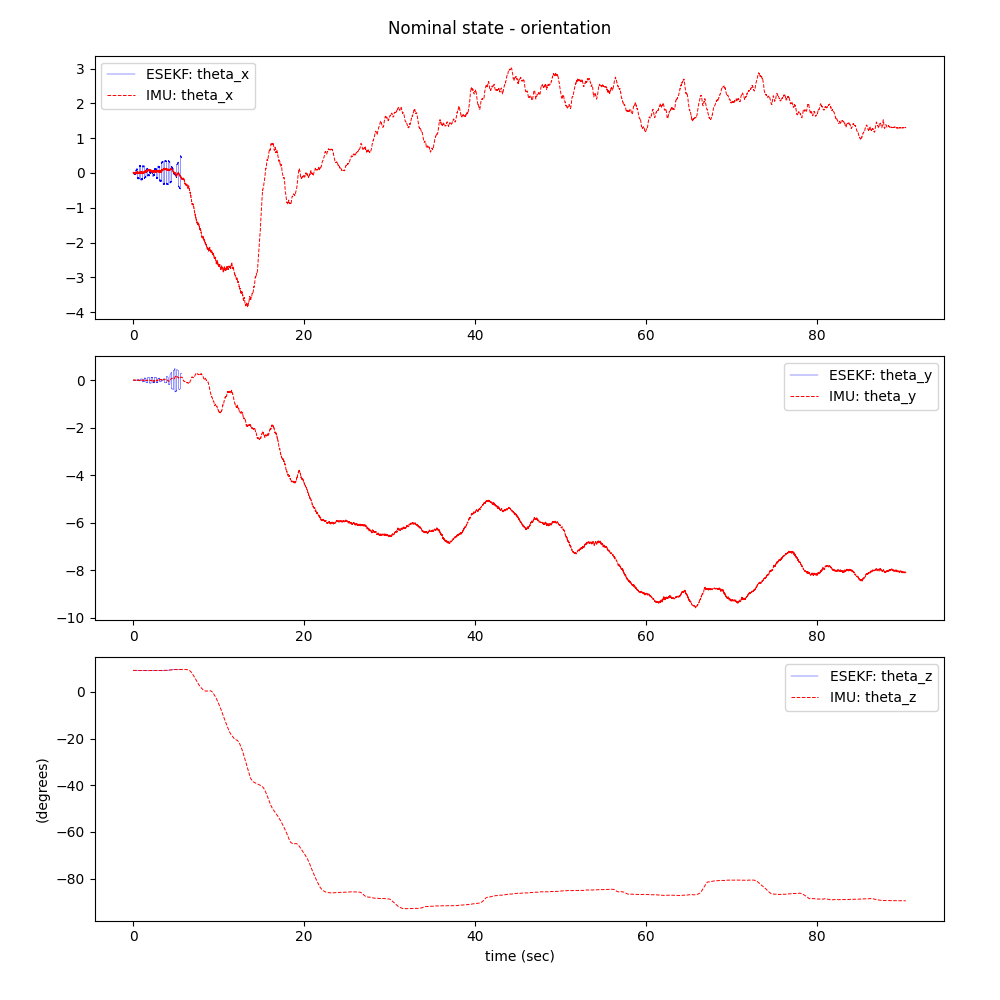

/tmp/ipykernel_105324/523505849.py:30: RuntimeWarning: invalid value encountered in true_divide
  w = (e_list[i,:] - e_list[i-1, :])/(t_list[i] - t_list[i-1])


In [123]:
vis_ori(t_list, x_list, t_imu, e_imu)

In [ ]:
# vis_wb(t_list, x_list, wb_imu)

In [ ]:
# vis_p(t_list, x_list, t_gps, p_gps)

In [ ]:
# vis_v(t_list, x_list, t_gps, v_gps, t_radar, v_ro_list, t_ro_list)

In [ ]:
# vis_pol_v(t_list, x_list, t_gps, v_gps, v_ro_list, t_ro_list)

In [ ]:
# vis_traj_2d(x_list, p_gps)

In [ ]:
# vis_traj_3d(x_list, p_gps)